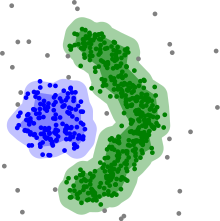

In [2]:
import numpy as np
import pandas as pd

For Complexity Analysis of this algorithm, there are two assumptions:
1. Number of clusters ~ log(Number of Points)
2. Number of neighbors a point has ~ log(Number of points in the cluster that point belongs to) = log(n/log(n))

In [3]:
class Point:
    def __init__(self, coordinates, type, neighboringPoints, cluster):
        self.coordinates = coordinates
        self.type = type #1 for core point, 2 for border point, 3 for outlier
        self.neighboringPoints = neighboringPoints
        self.cluster = cluster #1, 2, 3, ... when it has been assigned to a cluster

def EuclDist(x, p, eps, MinPts):
    NeighboringPoints = []
    type = 0
    for j in range(len(x)):
        point = x[j]
        dist = 0
        for i in range(len(point)):
            dist = dist + (point[i] - p[i])**2
        dist = dist**(1/2)
        if (dist < eps):
            NeighboringPoints.append(j)
    if (len(NeighboringPoints) > MinPts):
        type = 1 #core point
    elif (len(NeighboringPoints) > 1):
        type = 2 #border point
    else:
        type = 3 #outlier
    return [NeighboringPoints, type]

def DBscan(x, eps, MinPts): #x is a numpy array of lists. The list contains the coordinates of the datapoints.
    currentCluster = 0 
    points = []
    for data in x: #Step 1: Initialize points as core, border, or outlier points; O(n^2)
        [NeighboringPoints, type] = EuclDist(x, data, eps, MinPts)
        points.append(Point(data, type, NeighboringPoints, 1 - type))
    for i in range(len(x)): #Loop through all datapoints
        if points[i].cluster == 0: #if a point is a core point and it has not been clustered yet
                                   #Since there are log(n) clusters, you encounter an unclustered core point log(n) times
            currentCluster = currentCluster + 1
            points[i].cluster = currentCluster
            findClusterPoints(x, currentCluster, points, i, eps, MinPts)
    return points

def findClusterPoints(x, currentCluster, points, position, eps, MinPts): #Step 2b; [log(n/log(n))]^[log(n/log(n))]
    ClusterMembers = points[position].neighboringPoints
    i = 0
    while (i < len(ClusterMembers)):
        expansionPoint = ClusterMembers[i] #set an expansion point
        if (points[expansionPoint].cluster == -1): #if it's a border point that has NOT been assigned to a cluster
            points[expansionPoint].cluster = currentCluster
        elif (points[expansionPoint].cluster == 0): #if it's a core point that has NOT been assigned to a cluster
            points[expansionPoint].cluster = currentCluster
            ClusterMembers = ClusterMembers + points[expansionPoint].neighboringPoints
        i = i + 1

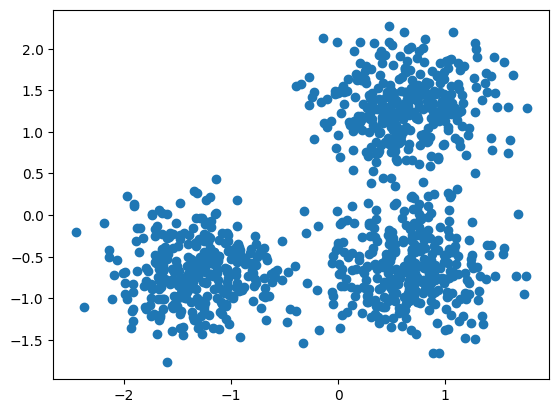

In [17]:
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=1000, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)
plt.scatter(X[:,0], X[:,1])

In [21]:
points = DBscan(X, eps = 0.2, MinPts = 5)
#points[i].type = Point i's type
#points[i].cluster = which cluster point i belongs to
clusters = []
for point in points:
    clusters.append(point.cluster)

In [26]:
df = pd.DataFrame(X, columns = ["x", "y"])
df['clusters'] = np.array(clusters)
df = df.sort_values("clusters")
df['clusters'] = df['clusters'].apply(lambda x: 'Outliers' if x == -2 else x)
df['clusters'] = df['clusters'].apply(lambda x: "Border points that don't belong to clusters" if x == -1 else x)
df

,x,y,clusters
163,1.252066,-0.077989,Outliers
128,-0.315955,0.043284,Outliers
135,1.729478,-0.948866,Outliers
380,-0.327667,-1.539195,Outliers
91,-2.445516,-0.200355,Outliers
...,...,...,...
323,-1.197630,-0.711529,3
698,-1.183450,-0.142778,3
697,-1.544238,-0.224390,3
216,-1.138861,-0.595767,3


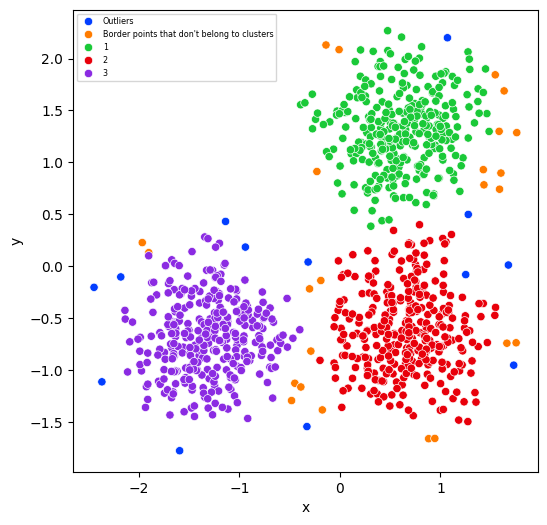

In [50]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data = df, x = "x", y = "y", hue = "clusters", palette = "bright")
plt.legend(fontsize='xx-small')
plt.show()

In [57]:
from sklearn.cluster import DBSCAN
import time
ourTimes = []
sklearnTimes = []
centers = [[1, 1], [-1, -1], [1, -1]]
for i in range(10):
    X, labels_true = make_blobs(
        n_samples=200 * (i + 1), centers=centers, cluster_std=0.4, random_state=0
    )
    X = StandardScaler().fit_transform(X)
    start = time.time()
    db = DBSCAN(eps=0.3, min_samples=5).fit(X)
    end = time.time()
    sklearnTimes.append(end - start)
    start = time.time()
    points = DBscan(X, 0.3, 5)
    end = time.time()
    ourTimes.append(end-start)

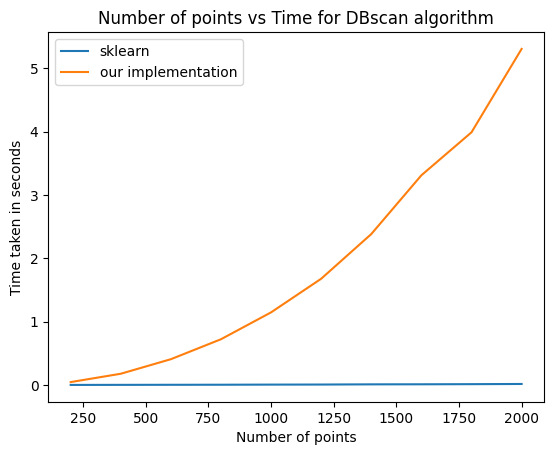

In [64]:
#We note a quadratic relationship between number of points and time taken
xaxis = [200 * (i+1) for i in range(10)]
plt.plot(xaxis, sklearnTimes)
plt.plot(xaxis, ourTimes)
plt.title('Number of points vs Time for DBscan algorithm')
plt.xlabel('Number of points')
plt.ylabel('Time taken in seconds')
plt.legend(['sklearn', 'our implementation'])
plt.show()